# <center>Porównanie modeli prognozowania szeregów czasowych opartych na stochastycznych równaniach różniczkowych, uczeniu maszynowym i modeli ekonometrycznych </center>
#### <center>Weronika Sadzik, Tomasz Czech</center>


In [5]:
import numpy as np
import pylab
from tqdm.notebook import tqdm
import math
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

In [6]:
data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data = data.iloc[2190:].resample('1D').first().ffill()

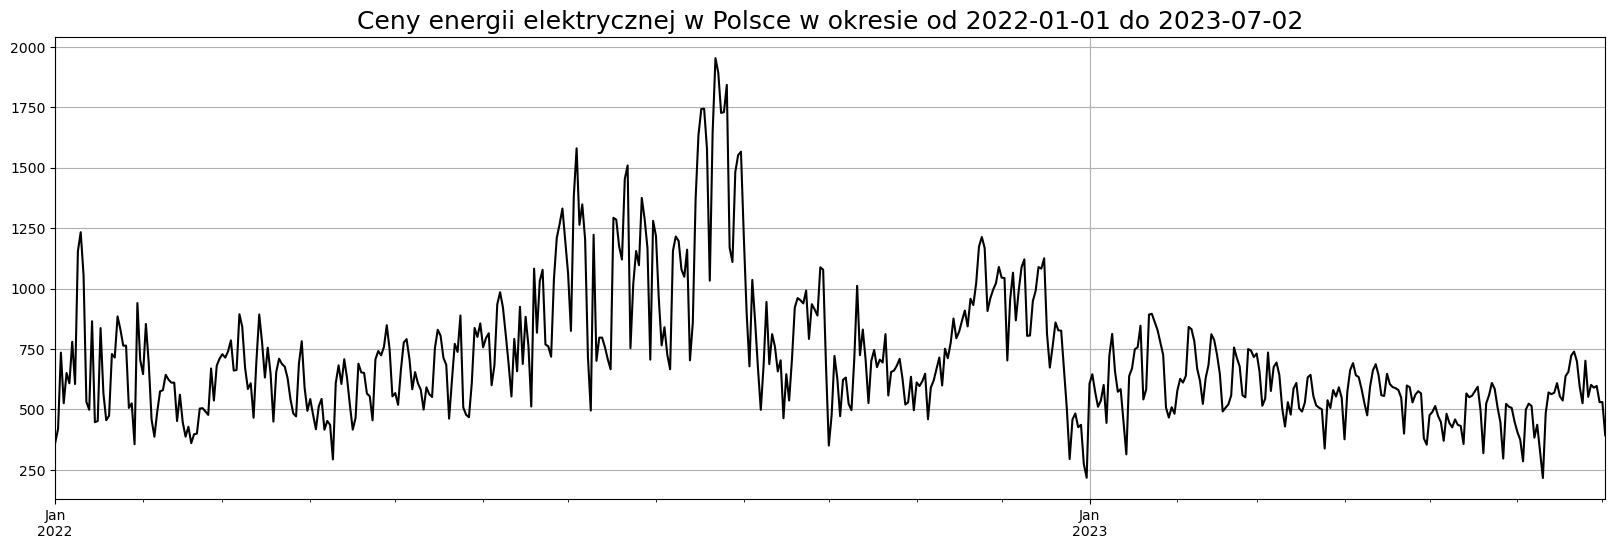

In [7]:
plt.rcParams["figure.figsize"] = (20,6)
data.plot(legend=False, color='black')
date_from = data.index[0].strftime('%Y-%m-%d')
date_to = data.index[-1].strftime('%Y-%m-%d')
plt.title(f'Ceny energii elektrycznej w Polsce w okresie od {date_from} do {date_to}', fontsize=18)
plt.xticks([datetime.strptime(f'{year}-01-01', '%Y-%m-%d') for year in [2022 + 1*i for i in range(2)]])
plt.xlabel('')
plt.grid()
plt.show()

In [54]:
class SDE:
    def __init__(self, drift, diffusion, data):
        self.drift = drift
        self.diffusion = diffusion
        self.data = data

    def estimate_parameters_mle(self, initial_guess_drift, initial_guess_diffusion):
        def log_likelihood(params, data):
            n = len(data)
            sum_log_likelihood = 0
            for i in range(1, n):
                drift = self.drift(*params[:len(initial_guess_drift)], data[i-1])
                diffusion = self.diffusion(*params[len(initial_guess_drift):], data[i-1])
                log_likelihood = -np.log(diffusion) - ((data[i] - data[i-1] - drift)**2) / (2 * diffusion**2)
                sum_log_likelihood += log_likelihood
            return -sum_log_likelihood

        initial_guess = initial_guess_drift + initial_guess_diffusion
        result = minimize(log_likelihood, initial_guess, args=(self.data.values,), method='Nelder-Mead')

        self.drift = (lambda f: lambda x: f(*result.x[:len(initial_guess_drift)], x))(self.drift)
        self.diffusion = (lambda f: lambda x: f(*result.x[len(initial_guess_drift):], x))(self.diffusion)

        return result.x

    @staticmethod
    def Wiener(h, n):
        w = np.zeros(n+1)
        for i in range(1, n+1):
            w[i] = w[i-1] + np.sqrt(h) * np.random.normal(0, 1)
        return w

    def Euler_Maruyama(self, num_simulations, window_size_days, plot=True):
        dates = self.data.index
        n = len(dates)
        x0 = self.data.values[0]
        h = 1 / window_size_days
        x = np.zeros((num_simulations, n))
        x[:, 0] = x0

        for i in range(num_simulations):
            w = self.Wiener(h, window_size_days)
            for j in range(1, n):
                if j < window_size_days:
                    dW = w[j] - w[j-1]
                else:
                    dW = np.sqrt(h) * np.random.normal(0, 1)
                x[i, j] = x[i, j-1] + self.drift(x[i, j-1]) * h + self.diffusion(x[i, j-1]) * dW

        df = pd.DataFrame(x.T, columns=[f'Simulation {i+1}' for i in range(num_simulations)])
        df['Date'] = dates
        df = df.set_index('Date')

        if plot:
            plt.figure(figsize=(10, 6))
            for i in range(num_simulations):
                plt.plot(df.index, df[f'Simulation {i+1}'])
            self.data.plot(color='black')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.title(f'{num_simulations} SDE simulations with real data')
            plt.xticks(rotation=45)
            plt.grid(True)
            plt.show()

        return df

    def goodness_of_fit_test(self, num_simulations, threshold, num_bins=30):
        simulated_data = self.Euler_Maruyama(num_simulations, False).mean(axis=1).values
        observed_freq, _ = np.histogram(self.data.values, bins=num_bins)
        expected_freq, _ = np.histogram(simulated_data, bins=num_bins)
        chi2_stat, p_value = chi2_contingency(np.array([observed_freq, expected_freq]))[:2]
        result = "Lack-of-fit" if p_value < threshold else "Goodness-of-fit"
        return chi2_stat, p_value, result

    def train_on_time_windows(self, window_size_days, initial_guess_drift, initial_guess_diffusion):
        results = []
        start_date = self.data.index[0]
        end_date = self.data.index[-1]
        current_date = start_date

        while current_date + timedelta(days=window_size_days) <= end_date:
            window_data = self.data.loc[current_date:current_date + timedelta(days=window_size_days)]
            if len(window_data) > 1:
                sde_window = SDE(self.drift, self.diffusion, window_data)
                drift_coef, diffusion_coef = sde_window.estimate_parameters_mle(initial_guess_drift, initial_guess_diffusion)
                results.append((current_date, drift_coef, diffusion_coef))
            current_date += timedelta(days=1)

        results_df = pd.DataFrame(results, columns=['Date', 'Drift Coefficients', 'Diffusion Coefficients'])
        results_df.set_index('Date', inplace=True)

        # plt.figure(figsize=(12, 6))
        # plt.plot(results_df.index, [coef for coef in results_df['Drift Coefficients']], label='Drift Coefficients')
        # plt.plot(results_df.index, [coef for coef in results_df['Diffusion Coefficients']], label='Diffusion Coefficients')
        # plt.xlabel('Date')
        # plt.ylabel('Coefficient Value')
        # plt.title('Drift and Diffusion Coefficients Over Time')
        # plt.legend()
        # plt.grid(True)
        # plt.show()

        return results_df

    def plot_predictions_based_on_windows(self, window_size_days, num_simulations, initial_guess_drift, initial_guess_diffusion):
        results_df = self.train_on_time_windows(window_size_days, initial_guess_drift, initial_guess_diffusion)
        start_date = self.data.index[0]
        end_date = self.data.index[-1]
        current_date = start_date

        # Create a DataFrame to store predictions for each simulation
        predictions = pd.DataFrame(index=self.data.index, columns=[f'Simulation {i+1}' for i in range(num_simulations)])

        while current_date + timedelta(days=window_size_days) <= end_date:
            window_data = self.data.loc[current_date:current_date + timedelta(days=window_size_days)]
            if len(window_data) > 1:
                sde_window = SDE(self.drift, self.diffusion, window_data)
                sde_window.estimate_parameters_mle(initial_guess_drift, initial_guess_diffusion)
                simulated_paths = sde_window.Euler_Maruyama(num_simulations, window_size_days, plot=False)

                start_idx = self.data.index.get_loc(current_date)
                end_idx = start_idx + len(window_data)

                for sim in range(num_simulations):
                    predictions.iloc[start_idx:end_idx, sim] = simulated_paths.iloc[:len(window_data), sim]

            current_date += timedelta(days=1)

        plt.figure(figsize=(12, 6))
        plt.plot(self.data.index[-100:], self.data.values[-100:], label='Actual Data', color='black')
        for i in range(num_simulations):
            plt.plot(predictions.index[-100:], predictions[f'Simulation {i+1}'][-100:], alpha=0.3)
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Predictions Based on Time Windows')
        plt.legend()
        plt.grid(True)
        plt.show()

        return predictions


# drift_coef, diffusion_coef = sde.estimate_parameters_mle([0.9], [0.5])
# print(f'Results from MLE:\n  drift: {drift_coef}\n  diffusion: {diffusion_coef}')
# sde.Euler_Maruyama(15)
# chi2_stat, p_value, result = sde.goodness_of_fit_test(1000, 0.05)
# print(f'Results from Goodness-of-Fit test:\n  Chi-square statistic: {chi2_stat}\n  p-value: {p_value}\n  Result: {result}')

## Model Blacka-Scholesa

Równanie Blacka-Scholesa:

$dX(t) = \mu X(t) dt + \sigma X(t) d W_t$

$X(t)$ - cena energii w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$, $\sigma > 0$

$W_t$ - proces Wienera

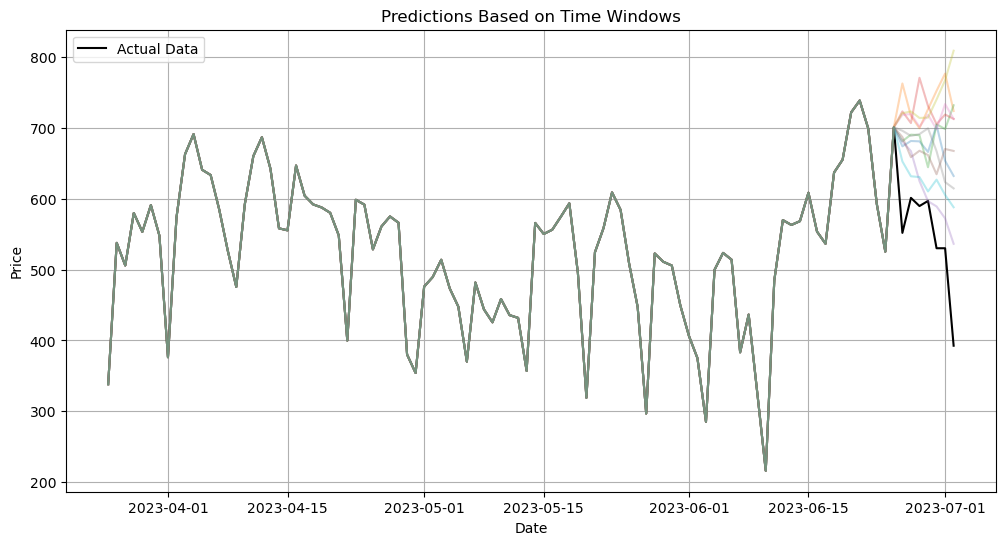

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10
date,,,,,,,,,,
2022-01-01,362.38,362.38,362.38,362.38,362.38,362.38,362.38,362.38,362.38,362.38
2022-01-02,419.05,419.05,419.05,419.05,419.05,419.05,419.05,419.05,419.05,419.05
2022-01-03,734.85,734.85,734.85,734.85,734.85,734.85,734.85,734.85,734.85,734.85
2022-01-04,525.46,525.46,525.46,525.46,525.46,525.46,525.46,525.46,525.46,525.46
2022-01-05,650.69,650.69,650.69,650.69,650.69,650.69,650.69,650.69,650.69,650.69
...,...,...,...,...,...,...,...,...,...,...
2023-06-28,681.295946,699.90319,690.02933,771.120141,625.185043,668.027546,701.903762,691.563174,714.409303,630.810146
2023-06-29,666.315094,726.741123,644.72628,731.352646,596.714598,661.918842,718.869049,699.724987,714.845341,610.561222
2023-06-30,704.269198,752.69109,705.492759,705.610143,589.349369,634.821979,698.388891,667.415683,740.417916,627.164361


In [55]:
drift = lambda mu, x: mu * x
diffusion = lambda sigma, x: sigma * x
# sde = SDE(drift, diffusion, data)
# predictions = sde.plot_predictions_based_on_windows(7, 10, [0.9], [0.5])
# print(predictions)

sde = SDE(drift, diffusion, data)
initial_guess_drift = [0.1]
initial_guess_diffusion = [0.1]
sde.plot_predictions_based_on_windows(window_size_days=7, num_simulations=10, initial_guess_drift=initial_guess_drift, initial_guess_diffusion=initial_guess_diffusion)

## Model Ornsteina-Uhlenbecka

Model jest postaci:
    
$dX(t) = -\mu X(t) dt + \sigma d W_t$

$X(t)$ - cena energii w t-tym momencie

$t\in [0;T]$, $\mu \in \mathbb{R}$, $\sigma > 0$

$W_t$ - proces Wienera

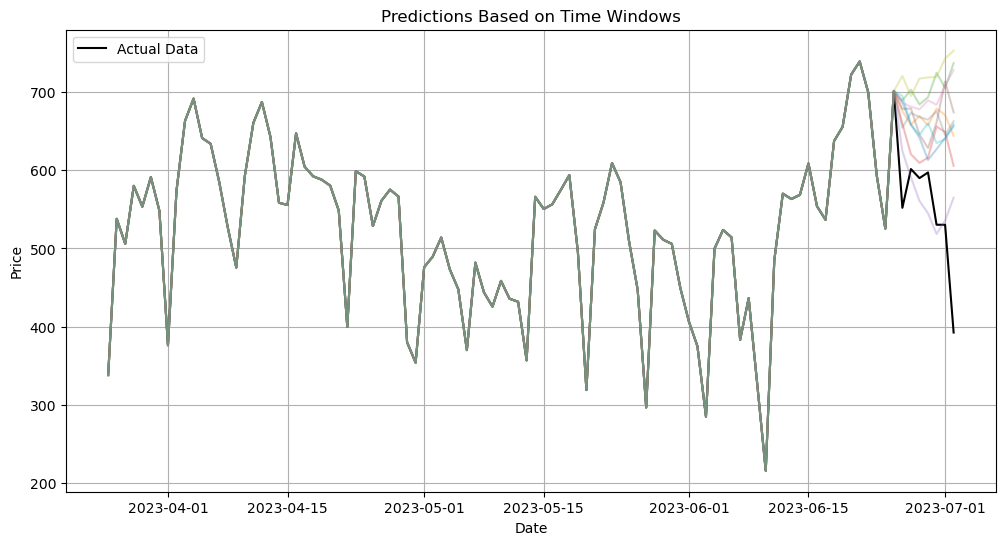

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10
date,,,,,,,,,,
2022-01-01,362.38,362.38,362.38,362.38,362.38,362.38,362.38,362.38,362.38,362.38
2022-01-02,419.05,419.05,419.05,419.05,419.05,419.05,419.05,419.05,419.05,419.05
2022-01-03,734.85,734.85,734.85,734.85,734.85,734.85,734.85,734.85,734.85,734.85
2022-01-04,525.46,525.46,525.46,525.46,525.46,525.46,525.46,525.46,525.46,525.46
2022-01-05,650.69,650.69,650.69,650.69,650.69,650.69,650.69,650.69,650.69,650.69
...,...,...,...,...,...,...,...,...,...,...
2023-06-28,641.575816,669.438046,684.148508,609.324681,560.645564,645.597198,677.829258,667.85809,717.192795,645.396954
2023-06-29,613.078412,657.350659,693.271094,616.082161,545.015813,628.376687,689.288044,664.620313,718.501405,660.045385
2023-06-30,626.881257,678.646384,724.544957,655.871383,518.479638,661.016362,683.617325,675.260657,719.307102,634.664832


In [ ]:
drift = lambda mu, x: -mu * x
diffusion = lambda sigma, x: sigma * np.ones_like(x)
sde = SDE(drift, diffusion, data)
initial_guess_drift = [0.1]
initial_guess_diffusion = [0.1]
sde.plot_predictions_based_on_windows(window_size_days=7, num_simulations=10, initial_guess_drift=initial_guess_drift, initial_guess_diffusion=initial_guess_diffusion)

## Model Ekonometryczny - ARIMA

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  542
Model:                ARIMA(16, 1, 0)   Log Likelihood               -3438.343
Date:                Mon, 10 Jun 2024   AIC                           6910.687
Time:                        09:12:10   BIC                           6983.675
Sample:                    01-01-2022   HQIC                          6939.230
                         - 06-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2530      0.037     -6.899      0.000      -0.325      -0.181
ar.L2         -0.3479      0.039     -8.864      0.000      -0.425      -0.271
ar.L3         -0.1875      0.040     -4.715      0.0

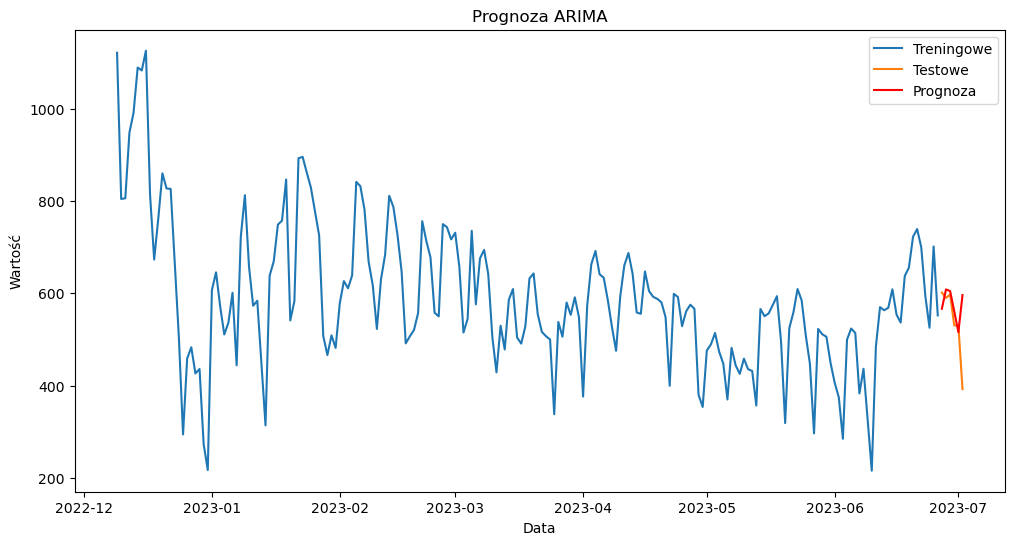

Błąd średniokwadratowy (MSE): 7364.9157214965335


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data = data.iloc[2190:].resample('1D').first().ffill()

train_size = int(len(data) * 0.99)
train, test = data.iloc[:train_size], data.iloc[train_size:]

model = ARIMA(train, order=(16, 1, 0))  # (p, d, q) - te wartości mogą być dostosowane
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
forecast_index = test.index

plt.figure(figsize=(12, 6))
plt.plot(train.index[-200:], train[-200:], label='Treningowe')
plt.plot(test.index, test, label='Testowe')
plt.plot(forecast_index, forecast, label='Prognoza', color='red')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Wartość')
plt.title('Prognoza ARIMA')
plt.show()

mse = mean_squared_error(test, forecast)
print(f'Błąd średniokwadratowy (MSE): {mse}')

## Model ML

In [111]:
data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data = data.iloc[2190:].resample('1D').first().ffill()
data["lag1"] = data.shift(1)
data["lag7"] = data.shift(7)
data["lag30"] = data.shift(30)
data.dropna(inplace=True)


date
2022-01-01    362.38
2022-01-02    419.05
2022-01-03    734.85
2022-01-04    525.46
2022-01-05    650.69
               ...  
2023-06-28    589.88
2023-06-29     597.1
2023-06-30    530.25
2023-07-01    530.25
2023-07-02    392.48
Name: value, Length: 548, dtype: object

          date   value    lag1    lag7   lag30
30  2022-01-31  704.29  939.96  830.87  362.38
31  2022-02-01  645.92  704.29  763.74  419.05
32  2022-02-02  853.58  645.92  763.74  734.85
33  2022-02-03  691.86  853.58  506.16  525.46
34  2022-02-04  458.76  691.86  525.08  650.69
..         ...     ...     ...     ...     ...
543 2023-06-28  589.88  601.44  739.03  511.13
544 2023-06-29  597.10  589.88  699.45  505.80
545 2023-06-30  530.25  597.10  593.05  449.37
546 2023-07-01  530.25  530.25  525.44  406.51
547 2023-07-02  392.48  530.25  701.32  374.93

[518 rows x 5 columns]


b
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-53772.171 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-280699.611 total time=   0.1s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-127601.030 total time=   0.1s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-75226.607 total time=   0.1s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=-34370.158 total time=   0.2s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-8971.380 total time=   0.6s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-52408.879 total time=   0.6s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-24185.978 total time=   0.7s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=500;, score=-16043.972 total time=   0.5s
[CV 5/5] END learning_rate

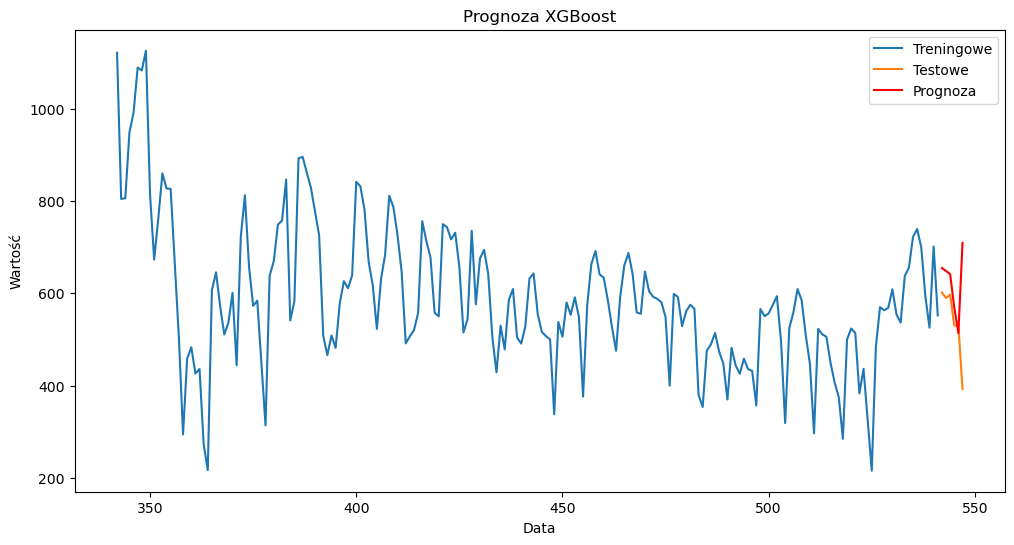

Błąd średniokwadratowy (MSE): 18390.705975288667


In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

data = pd.read_csv('ceny_energii_pl.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data = data.squeeze()
data = data.iloc[2190:].resample('1D').first().ffill().reset_index()
data["lag1"] = data.value.shift(1)
data["lag7"] = data.value.shift(7)
data["lag30"] = data.value.shift(30)
data.dropna(inplace=True)

def create_features(df, train=True, label=None):
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day

    X = df[['dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth', 'lag1', 'lag7', 'lag30']]
    if label:
        y = df[label]
        return X, y
    return X

train_size = int(len(data) * 0.99)
train, test = data.iloc[:train_size], data.iloc[train_size:]
X_train, y_train = create_features(train, label='value')
X_test, y_test = create_features(test, label='value')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
}
print("b")
xgb = XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=3)

grid_search.fit(X_train_scaled, y_train)

print(f'Najlepsze parametry: {grid_search.best_params_}')

best_model = grid_search.best_estimator_

forecast = best_model.predict(X_test_scaled)

plt.figure(figsize=(12, 6))
plt.plot(train.index[-200:], train[-200:].value, label='Treningowe')
plt.plot(test.index, test.value, label='Testowe')
plt.plot(test.index, forecast, label='Prognoza', color='red')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Wartość')
plt.title('Prognoza XGBoost')
plt.show()

mse = mean_squared_error(y_test, forecast)
print(f'Błąd średniokwadratowy (MSE): {mse}')

**Modele oparte na stochastycznych równaniach różniczkowych (SDE)**

Zalety:

- Zdolność do modelowania ciągłych procesów w czasie.
- Uwzględnianie wpływu losowych zakłóceń.
- Przydatne w dziedzinach takich jak finanse i fizyka.
- Możliwość modelowania złożonych, nieliniowych zależności.
- Możliwość uzyskania przedziałów predykcji

Wady:

- Skomplikowana implementacja i wymagania dotyczące zaawansowanej matematyki.
- Estymacja parametrów jest trudna i czasochłonna.
- Trudna interpretacja wyników bez odpowiedniego przygotowania matematycznego.

**Modele ekonometryczne (ARIMA)**

Zalety:

- Prosta i dobrze zdefiniowana metodologia.
- Łatwe do zrozumienia i interpretacji.
- Skuteczne w modelowaniu liniowych zależności w danych.
- Relatywnie łatwe do wyznaczenia przedziały predykcji

Wady:

- Ograniczona zdolność do modelowania nieliniowości i skomplikowanych wzorców.
- Wrażliwość na wybór parametrów.
- Skuteczność maleje w przypadku dużej ilości danych lub złożonych wzorców.
- Wymóg stacjonarności danych, co może wymagać dodatkowej obróbki danych przed modelowaniem.
- Przedziały są oparte na założeniu normalności reszt, co nie zawsze jest spełnione.

**Modele machine learningowe (XGBoost)**

Zalety:

- Wysoka dokładność predykcji.
- Zdolność do modelowania skomplikowanych, nieliniowych zależności w danych.
- Elastyczność i zdolność do automatycznego wyboru najlepszych cech.

Wady:

- Skomplikowana implementacja i interpretacja w porównaniu do tradycyjnych modeli ekonometrycznych.
- Wymaga większej ilości danych do treningu.
- Możliwość przeuczenia, jeśli nie jest odpowiednio regularyzowany.
- Postrzegany jako „czarna skrzynka”, co utrudnia wyjaśnienie decyzji modelu.
- Przedziały predykcji mogą nie być bezpośrednio dostępne i mogą wymagać dodatkowych technik (np. bootstrapowanie).